In [3]:
import torch, pickle
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS

In [4]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/Exp2.1_KS_Num_seqlentest_N128_localtest_utmat_normmat"  #Experiment Directory
exp_name  = "sl32_nhu40_numobs16_bs16_lr5e-5"                #One of the experiment names

eval_mza = Eval_MZA(exp_dir, exp_name)

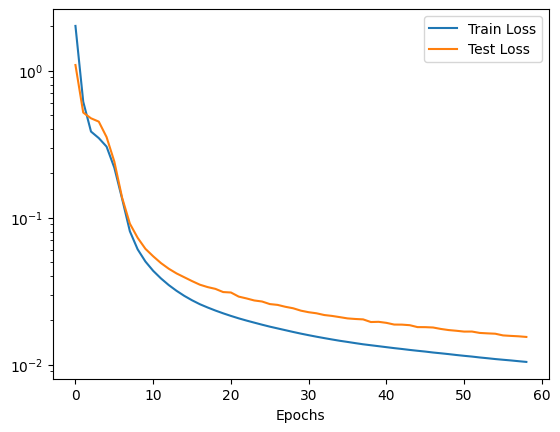

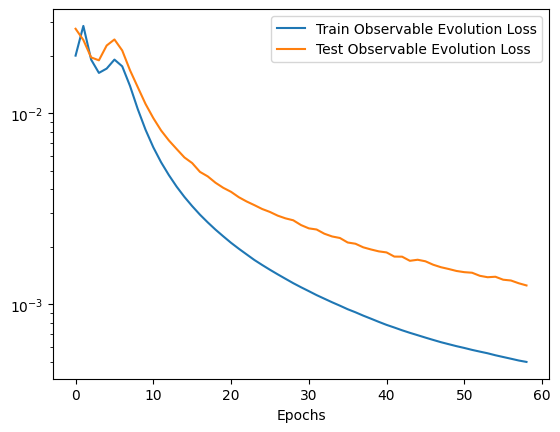

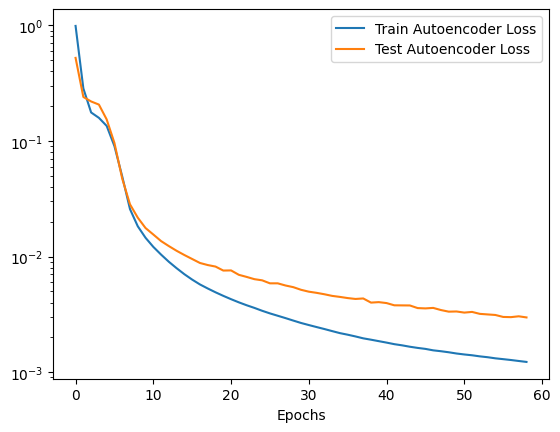

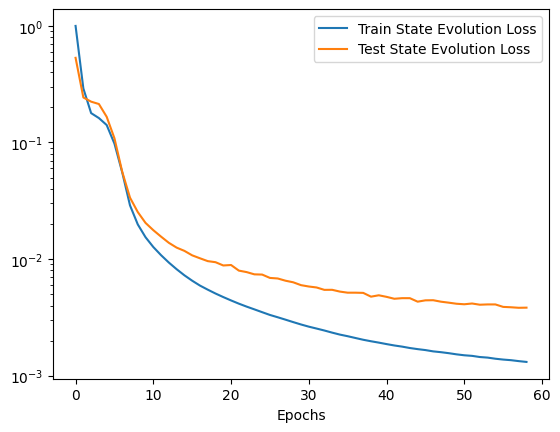

In [5]:
#plot learning curves
eval_mza.plot_learning_curves()

In [6]:
epoch_num = 50
eval_mza.load_weights(epoch_num)

In [7]:
# eval_mza.train_size = 0.9
eval_mza.load_and_preproc_data()
eval_mza.create_dataset(mode = "Train")
# del eval_mza.lp_data 
# torch.cuda.empty_cache()
# del eval_mza.train_dataset
# del eval_mza.train_dataloader
dataset = eval_mza.train_dataset
num_trajs = eval_mza.train_num_trajs
x_nn_hat, Phi_nn_hat, Phi_nn, State_MSE, koop_out, seqmodel_out = eval_mza.predict_onestep(dataset, num_trajs)

print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)


#Plotting one step prediction
x_nn_hat.shape


Data Shape:  (1, 17000, 128)
Not normalizing Input
Train_Shape:  (1, 13600, 128)
out of train
torch.Size([1, 13600, 16]) torch.Size([1, 13600, 128]) torch.Size([1, 13600, 128])


/home/pg221/anaconda3/envs/KS/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 13600, 16])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


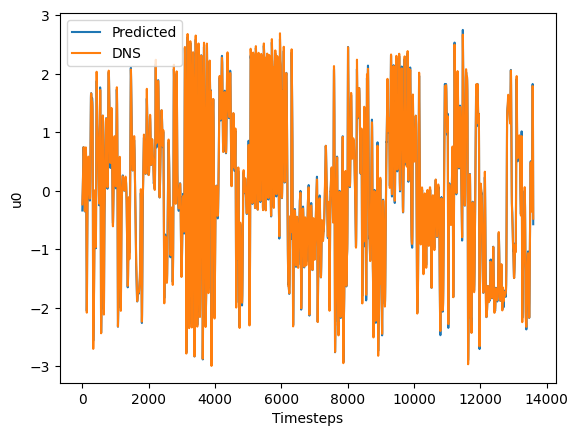

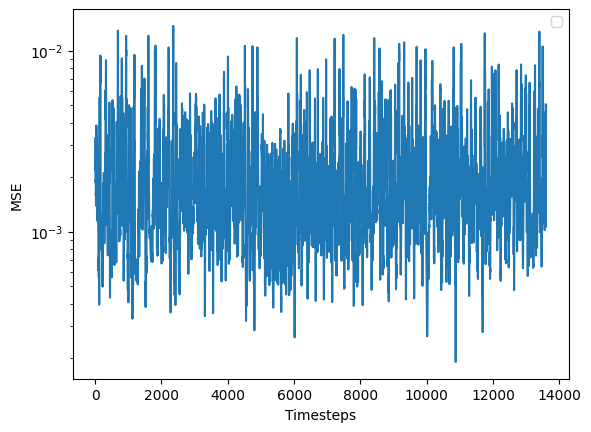

In [8]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


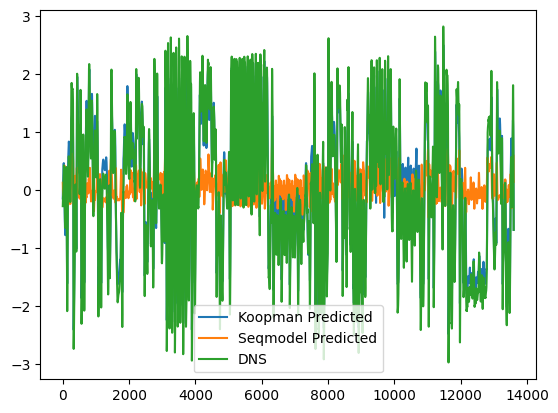

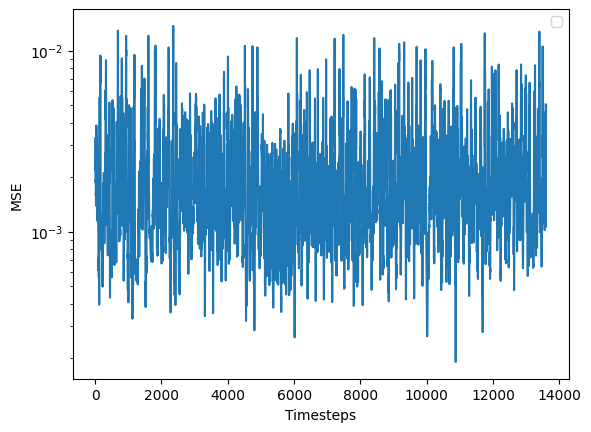

In [9]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

(1, 1000, 65)


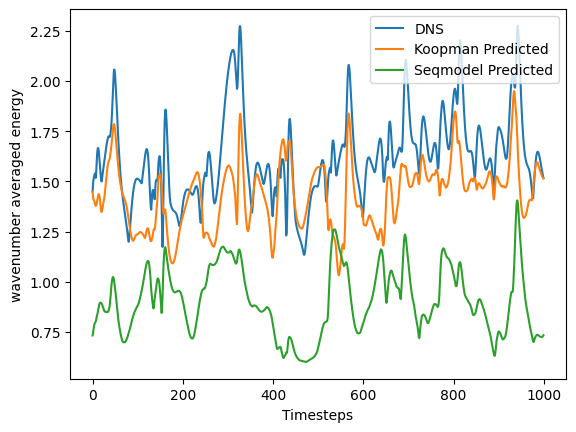

In [10]:

koop_out_fft = np.fft.rfft(koop_out[:,:1000,:].cpu().numpy())
seqmodel_out_fft = np.fft.rfft(seqmodel_out[:,:1000,:].cpu().numpy())
Phi_nn_fft = np.fft.rfft(Phi_nn[:,:1000,:].cpu().numpy())

print(koop_out_fft.shape)

koop_out_energy = 0.5*np.mean(np.abs(koop_out_fft),axis = -1)
seqmodel_out_energy = 0.5*np.mean(np.abs(seqmodel_out_fft),axis = -1)
Phi_nn_energy = 0.5*np.mean(np.abs(Phi_nn_fft),axis = -1)

koop_out_energy.shape

for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_energy[0,:], label = "DNS")
    plt.plot(koop_out_energy[0,:], label = "Koopman Predicted")
    plt.plot(seqmodel_out_energy[0,:], label = "Seqmodel Predicted")
    plt.legend()

# plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("wavenumber averaged energy")
plt.legend()




/home/pg221/anaconda3/envs/KS/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


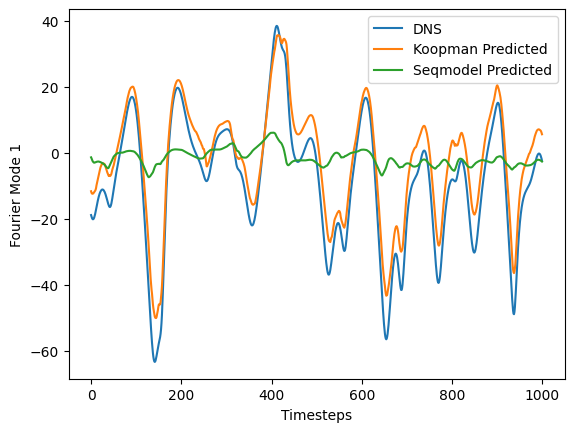

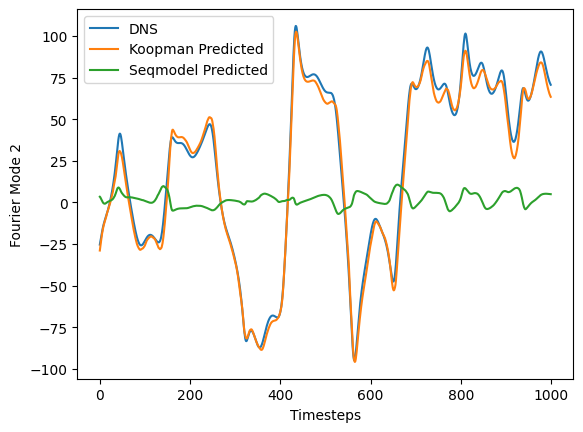

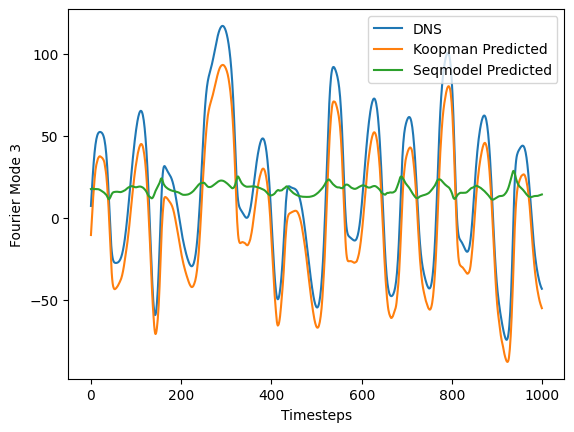

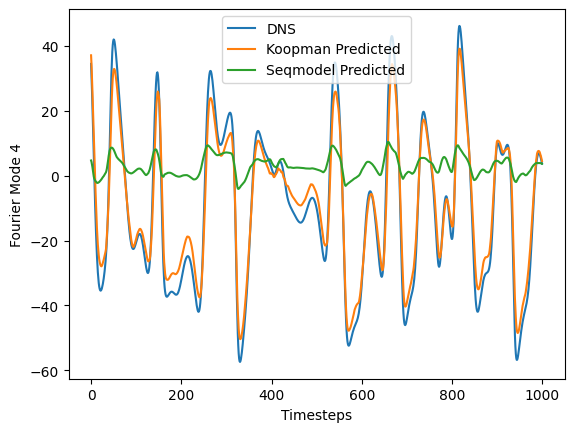

In [12]:
for i in range (1,5):
    plt.figure()
    plt.plot(Phi_nn_fft[0,:,i], label = "DNS")
    plt.plot(koop_out_fft[0,:,i], label = "Koopman Predicted")
    plt.plot(seqmodel_out_fft[0,:,i], label = "Seqmodel Predicted")
    plt.legend()


    # plt.semilogy(State_MSE.cpu().numpy())
    plt.xlabel("Timesteps")
    plt.ylabel(f"Fourier Mode {i}")
    plt.legend()

[  0.           0.29156312   0.58312625   0.87468937   1.16625249
   1.45781562   1.74937874   2.04094186   2.33250499   2.62406811
   2.91563123   3.20719436   3.49875748   3.7903206    4.08188373
   4.37344685   4.66500997   4.9565731    5.24813622   5.53969934
   5.83126247   6.12282559   6.41438871   6.70595184   6.99751496
   7.28907808   7.58064121   7.87220433   8.16376745   8.45533058
   8.7468937    9.03845682   9.33001995   9.62158307   9.91314619
  10.20470932  10.49627244  10.78783556  11.07939869  11.37096181
  11.66252493  11.95408806  12.24565118  12.5372143   12.82877743
  13.12034055  13.41190367  13.7034668   13.99502992  14.28659304
  14.57815617  14.86971929  15.16128241  15.45284554  15.74440866
  16.03597178  16.3275349   16.61909803  16.91066115  17.20222427
  17.4937874   17.78535052  18.07691364  18.36847677 -18.66003989]
[  0.           0.29156312   0.58312625   0.87468937   1.16625249
   1.45781562   1.74937874   2.04094186   2.33250499   2.62406811
   2.9156

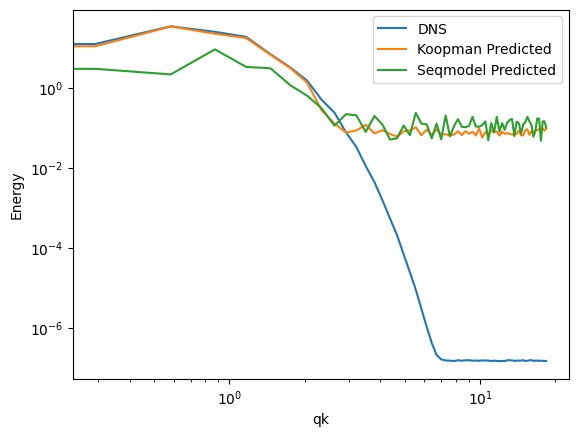

In [9]:
dt = 0.025
N  = 128
num_trajs = 1
max_n = int(8000/dt)
L = 21.55/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)



koop_out_energy = 0.5*np.mean(np.abs(koop_out_fft),axis = 1)
seqmodel_out_energy = 0.5*np.mean(np.abs(seqmodel_out_fft),axis = 1)
Phi_nn_energy = 0.5*np.mean(np.abs(Phi_nn_fft),axis = 1)

koop_out_energy.shape

for i in range (1):
    plt.figure()
    plt.loglog(kse.k[:-1], Phi_nn_energy[0,:-1], label = "DNS")
    plt.loglog(kse.k[:-1], koop_out_energy[0,:-1], label = "Koopman Predicted")
    plt.loglog(kse.k[:-1], seqmodel_out_energy[0,:-1], label = "Seqmodel Predicted")
    plt.legend()


# plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("qk")
plt.ylabel("Energy")
plt.legend()

print(kse.k)

In [14]:
#defining moving average
def moving_avg(u):

    pdu  = pd.DataFrame(u)
    u_ma = pdu.expanding().mean()
    return u_ma

# print(u_ma.shape)

# plt.plot(np.arange(u.shape[1]),u[...,0].squeeze(), label = "Mean Energy")
# plt.plot(u_ma)
# # plt.plot(np.arange(ref_X.shape[0]),ref_X_ma, linewidth = 3, label = "Time Moving Average")
# plt.xlabel("Time Units")
# plt.ylabel("Mean Energy")
# plt.legend()

In [15]:
Phi_nn_hat_ma = moving_avg(Phi_nn_hat.cpu().numpy())

plt.plot(Phi_nn_hat_ma)

ValueError: Must pass 2-d input. shape=(1, 13600, 128)

In [11]:
#multistep prediction
timesteps = 1000
initial_conditions = Phi_nn[:,0,:].to(eval_mza.device)
print(initial_conditions.shape)
x_hat, Phi_hat     = eval_mza.predict_multistep(initial_conditions, timesteps)

print(x_hat.shape, Phi_hat.shape)


torch.Size([1, 128])
torch.Size([1, 1001, 16]) torch.Size([1, 1001, 128])


In [12]:
eval_mza.deactivate_seqmodel

False

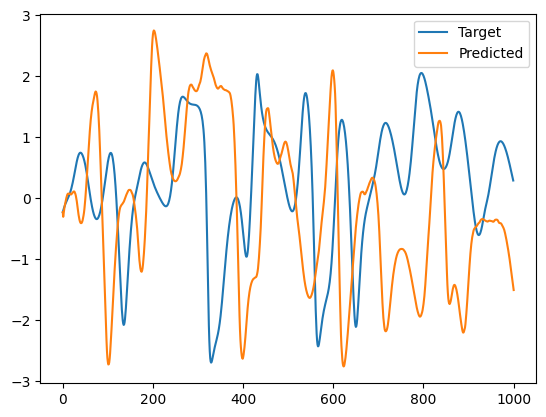

In [13]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn.cpu().numpy()[i,:timesteps,0], '-', label = "Target")
    plt.plot(Phi_hat.cpu().numpy()[i,:,0], '-', label = "Predicted")
    plt.legend()



torch.Size([1, 13600, 128]) torch.Size([1, 1001, 128])


Text(0, 0.5, 'MSE')

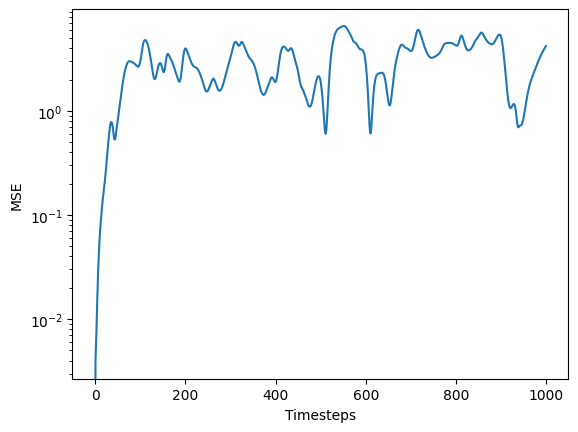

In [14]:
print(Phi_nn.shape, Phi_hat.shape)
State_MSE_multistep = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_hat[:,:timesteps])
plt.figure()
plt.semilogy(State_MSE_multistep.detach().cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [12]:
import numpy
k1 = np.load("koopman_numobs4.npy")
k2 = np.load("koopman_numobs16.npy")
k3 = np.load("koopman_numobs32.npy")
k1.shape

plt.figure()
# plt.plot(k1[:,0])
plt.plot(np.linspace(0,101,1001),k2[0,:,1], label = "Koopman")
plt.plot(np.linspace(0,101,1001),Phi_nn[0,:1001,1].cpu().numpy(), label = "Target")
plt.plot(np.linspace(0,101,1001),Phi_hat.cpu().numpy()[0,:,1], label = "MZA Memory = 0.4 timeunits")
# plt.plot(k3[:,0])
plt.legend()
plt.xlabel("Timeunits")
plt.ylabel("u1")
k2.shape

FileNotFoundError: [Errno 2] No such file or directory: 'koopman_numobs4.npy'

Text(0.5, 0, 'Epochs')

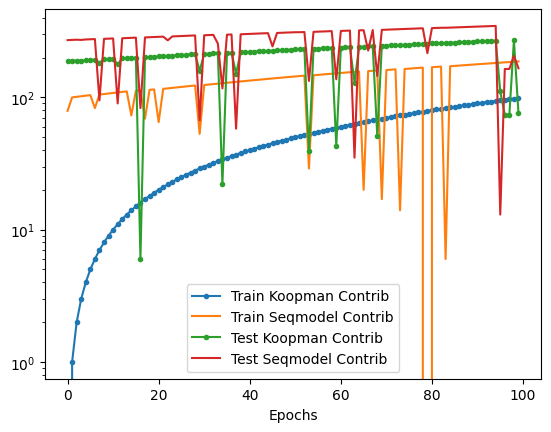

In [15]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_koop_ptg'], '.-',label="Train Koopman Contrib")
plt.semilogy(df['epoch'],df['Train_seqmodel_ptg'], label="Train Seqmodel Contrib")

plt.semilogy(df['epoch'], df['Test_koop_ptg'], '.-',label="Test Koopman Contrib")
plt.semilogy(df['epoch'], df['Test_seqmodel_ptg'], label="Test Seqmodel Contrib")

plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

<Figure size 640x480 with 0 Axes>

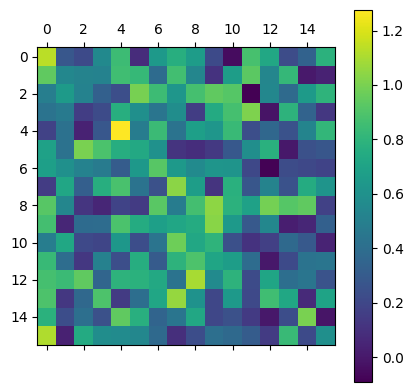

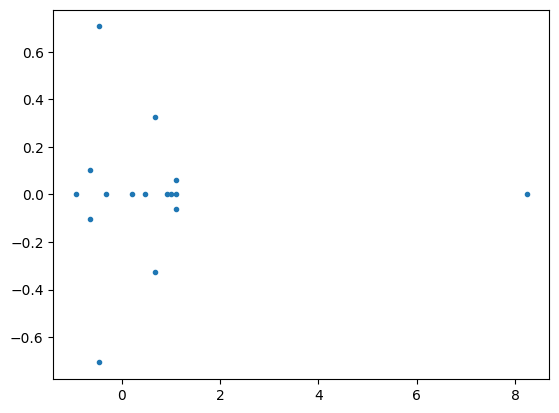

In [17]:
mat = eval_mza.model.koopman.getKoopmanMatrix()
mat = mat.detach().cpu().numpy()
w, v = np.linalg.eig(mat)

idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

plt.figure()
plt.matshow(mat)
plt.colorbar()

plt.figure()
plt.plot(np.real(w), np.imag(w), ".")

In [43]:
print(w)

[0.9914712+0.00552632j 0.9914712-0.00552632j 0.9856538+0.02271575j
 0.9856538-0.02271575j 0.9852751+0.01613129j 0.9852751-0.01613129j
 0.9845055+0.00399704j 0.9845055-0.00399704j 0.9776434+0.0418263j
 0.9776434-0.0418263j  0.9769968+0.01882195j 0.9769968-0.01882195j
 0.9658504+0.01091512j 0.9658504-0.01091512j 0.9295203+0.01905324j
 0.9295203-0.01905324j]


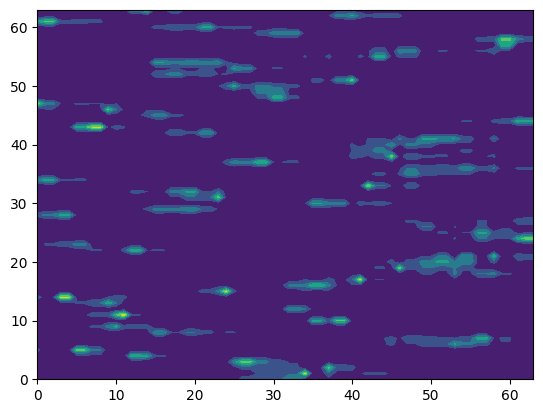

In [56]:
plt.contourf(abs(v))